### Imports

In [2]:
%pip install matplotlib
%pip install prophet
%pip install nbconvert
%pip install traitlets

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from pylab import rcParams
from datetime import datetime
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing
from sklearn.metrics import mean_squared_error, mean_absolute_error, median_absolute_error
from statsmodels.tsa.statespace.tools import diff
from statsmodels.tsa.stattools import acovf, acf, pacf, pacf_yw, pacf_ols
from pandas.plotting import lag_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, month_plot, quarter_plot
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import mse, rmse, meanabs, aic, bic
from pmdarima import auto_arima
from prophet import Prophet
from statsmodels.tsa.seasonal import seasonal_decompose
from datetime import datetime, timedelta
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from statsmodels.tsa.arima.model import ARIMA
from statistics import median,mean
import matplotlib.ticker as ticker
import pytz
import warnings
import scipy.stats as st
import math
import seaborn as sns
from pylab import rcParams
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
import pika
import sys
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline


[notice] A new release of pip available: 22.2.1 -> 22.2.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip available: 22.2.1 -> 22.2.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.2.1 -> 22.2.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip available: 22.2.1 -> 22.2.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


### Ingest Data

In [694]:
import json
import datetime
from datetime import timedelta
import random
import numpy as np
import pytz

data = pd.read_csv("../data/airlinetweets.csv", parse_dates=['tweet_created'], index_col=['tweet_created'])
data
datetime.datetime.utcfromtimestamp(1661181327).replace(tzinfo=pytz.utc)

true


## Data Exploratory Analysis

In [12]:
data.describe()
data_summary = data.groupby('airline_sentiment').resample('1d').count()[['tweet_id']]
data_summary = data_summary.unstack(0)
data_summary['total'] = data_summary.sum(axis = 1)
data_summary['tweet_id']['negative'].sum()

data_summary

tweet_id                    total
airline_sentiment         negative neutral positive        
tweet_created                                              
2015-02-16 00:00:00-08:00      3.0     1.0      NaN     4.0
2015-02-17 00:00:00-08:00    838.0   297.0    273.0  1408.0
2015-02-18 00:00:00-08:00    736.0   335.0    273.0  1344.0
2015-02-19 00:00:00-08:00    751.0   329.0    296.0  1376.0
2015-02-20 00:00:00-08:00    835.0   383.0    282.0  1500.0
2015-02-21 00:00:00-08:00   1049.0   278.0    230.0  1557.0
2015-02-22 00:00:00-08:00   2266.0   463.0    350.0  3079.0
2015-02-23 00:00:00-08:00   1919.0   676.0    433.0  3028.0
2015-02-24 00:00:00-08:00    781.0   337.0    226.0  1344.0

### Get Summary of Data

### Resample the data

In [13]:
#Resample the data
data['sentiment']=data['airline_sentiment'].map({'positive':1,'neutral':0,'negative':-1}) 
data_freq = 10 #in minutes
actual_positive_sentiments = data[data['sentiment']==1].resample(f'{data_freq}min').count()
actual_negative_sentiments = data[data['sentiment']==-1].resample(f'{data_freq}min').count()
actual_neutral_sentiments = data[data['sentiment']==0].resample(f'{data_freq}min').count()

In [174]:
import re
import pytz
import math

sample_frequencies = ['1min', '10min', '60min']

for sample_frequency in sample_frequencies:
    num_negative_in_past, sample_frequency_num = 0, int(re.findall(r'\d+', sample_frequency)[0])

    # offset_time = pytz.utc.localize(datetime.now()) - timedelta(minutes=sample_frequency_num)
    last_recorded_time = actual_negative_sentiments.sort_index().index[-1]
    offset_time = last_recorded_time - timedelta(minutes=sample_frequency_num)

    num_negative_in_past = actual_negative_sentiments.loc[actual_negative_sentiments.index >= offset_time]['sentiment'].sum()
    print(f"Number of negative posts in past {sample_frequency_num} minutes: {num_negative_in_past}")


Number of negative posts in past 1 minutes: 2
Number of negative posts in past 10 minutes: 21
Number of negative posts in past 60 minutes: 112


### Standardize the data

In [1312]:
# Standardize the data
standard_scaler_positive_sentiment = StandardScaler()
standard_scaler_negative_sentiment = StandardScaler()
standard_scaler_neutral_sentiment = StandardScaler()

actual_positive_sentiments[['sentiment_normalized']] = \
    standard_scaler_positive_sentiment.fit_transform(actual_positive_sentiments[['sentiment']])
actual_negative_sentiments[['sentiment_normalized']] = \
    standard_scaler_negative_sentiment.fit_transform(actual_negative_sentiments[['sentiment']])
actual_neutral_sentiments[['sentiment_normalized']] = \
    standard_scaler_neutral_sentiment.fit_transform(actual_neutral_sentiments[['sentiment']])

### Test for stationarity

In [1332]:
adfuller(actual_negative_sentiments['sentiment_normalized'])[1]

0.03503054692717735

p-value is less than 0.05% - should imply stationarity

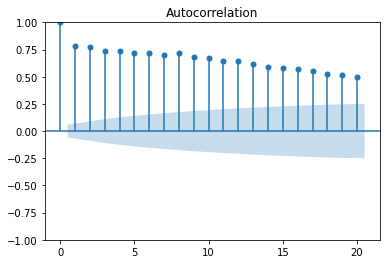

In [1314]:
plot_acf(actual_negative_sentiments['sentiment'], lags=20);

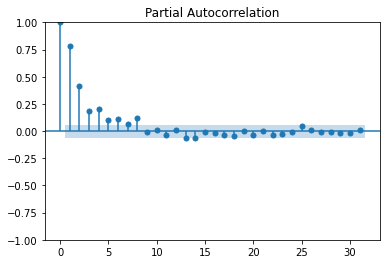

In [1315]:
plot_pacf(actual_negative_sentiments['sentiment_normalized']);

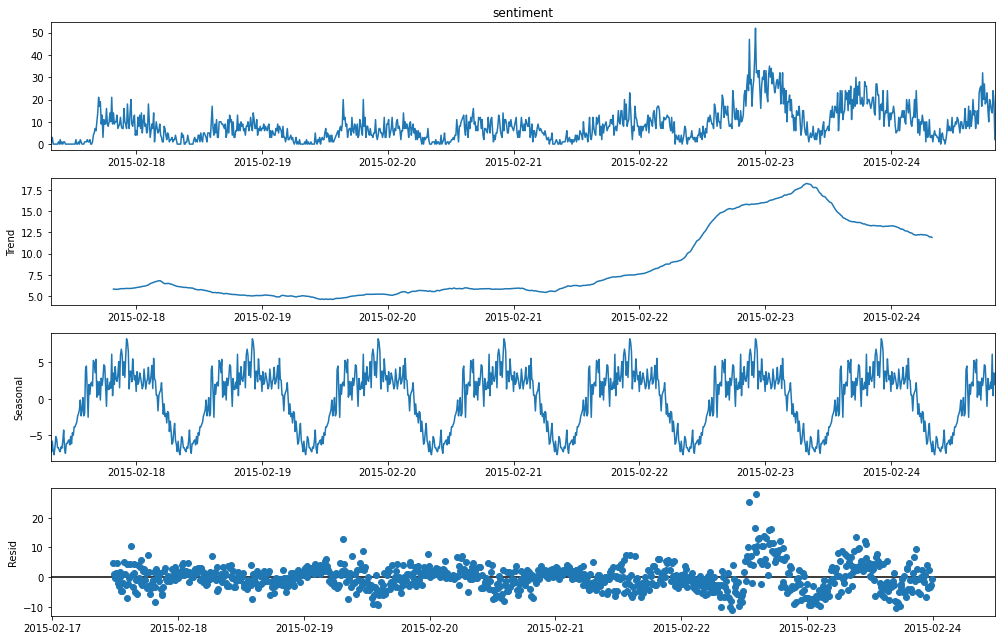

In [1316]:
rcParams['figure.figsize'] = (14, 9)
the_decompose = seasonal_decompose(actual_negative_sentiments['sentiment'],model='additive',period=144);
the_decompose.plot();

### Plot Data

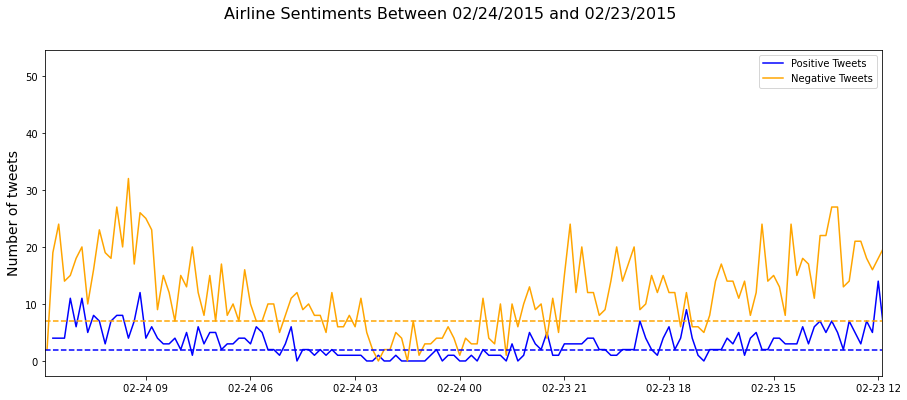

In [1356]:
start_date, end_date = data['sentiment'].index.max(), data['sentiment'].index.min()

start_date, end_date = data['sentiment'].index.max(), data['sentiment'].index.max() - timedelta(days=1)

fig, ax = plt.subplots(figsize=(15, 6))

fig.suptitle(f"Airline Sentiments Between {datetime.strftime(start_date, '%m/%d/%Y')} and {datetime.strftime(end_date, '%m/%d/%Y')}", fontsize=16)

ax.set_xlim([start_date,end_date])
ax.plot(actual_positive_sentiments['sentiment'],
         label="Positive Tweets", color="blue")
ax.plot(actual_negative_sentiments['sentiment'],
         label="Negative Tweets", color="orange")
ax.hlines(actual_positive_sentiments['sentiment'].median(), xmin=start_date, xmax=end_date, linestyles='--', colors='blue')
ax.hlines(actual_negative_sentiments['sentiment'].median(), xmin=start_date, xmax=end_date, linestyles='--', colors='orange')
ax.set_ylabel('Number of tweets', fontsize=14)
ax.legend()

# Training

### Generate an ARIMA model

In [1363]:
# Search for best-fit parameters
stepwise_fit = auto_arima(actual_negative_sentiments['sentiment_normalized'],start_p=0,start_q=0,max_p=6,max_q=6,
                         seasonal=False,trace=True)
stepwise_fit.summary()

(3, 1, 4)

### Train

In [1319]:
total_training_window = 1440 # (we assume a daily sample rate)

# The size of the sliding window
sliding_window_size = total_training_window/data_freq


actual_negative_sentiments_train = actual_negative_sentiments.iloc[:-int(sliding_window_size)]
model_arima_order = (3,1,4)

model_ARIMA = ARIMA(actual_negative_sentiments_train['sentiment_normalized'], order=model_arima_order) 
model_ARIMA_results = model_ARIMA.fit() #fit the model

### Detect Anomalies

In [1320]:
z_score = st.norm.ppf(.95) #95% confidence interval
mae_scale_factor = 0.67449 # MAE is 0.67449 * std
mae = median_absolute_error(model_ARIMA_results.fittedvalues,actual_negative_sentiments_train['sentiment_normalized'])

threshold = median(model_ARIMA_results.fittedvalues) + (z_score/mae_scale_factor)*mae
model_ARIMA_results_metrics = \
    pd.DataFrame({ 'fittedvalues' : model_ARIMA_results.fittedvalues, \
      'median_values' : model_ARIMA_results.fittedvalues.rolling(4).median().fillna(0)}, \
       index = model_ARIMA_results.fittedvalues.index )
model_ARIMA_results_metrics['threshold'] = model_ARIMA_results_metrics['median_values'] + (z_score/mae_scale_factor)*mae
model_ARIMA_results_metrics['anomaly'] = 0

model_ARIMA_results_metrics['actualvalues'] = actual_negative_sentiments_train['sentiment_normalized']
model_ARIMA_results_metrics['actualvalues'].fillna(0,inplace=True)

model_ARIMA_results_metrics.loc[model_ARIMA_results_metrics['actualvalues'] > model_ARIMA_results_metrics['threshold'],'anomaly']= 1
model_ARIMA_results_metrics['anomaly'].value_counts()

0    840
1     98
Name: anomaly, dtype: int64

### Plot Anomalies

Text(0.5, 1.0, 'ARIMA Model (Train): \n Median Absolute Error (MAE): 1.9212819457584622')

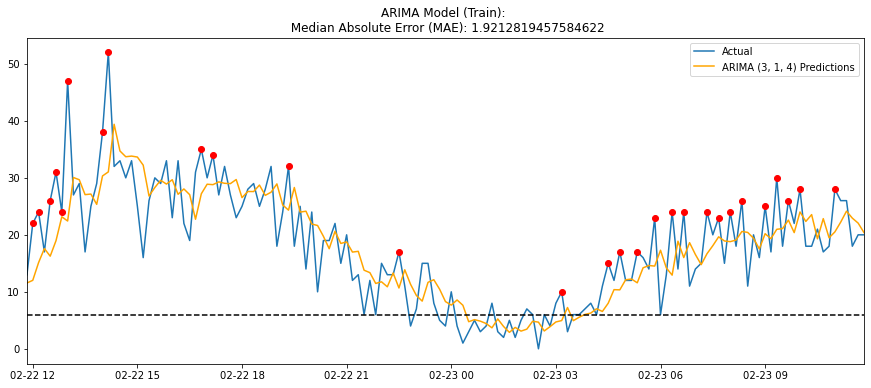

In [1321]:
#start_date, end_date = actual_negative_sentiments_train.index[0], actual_negative_sentiments_train.index[-1]
start_date, end_date = actual_negative_sentiments_train.index[-1] - timedelta(hours=24), actual_negative_sentiments_train.index[-1]
#start_date, end_date = actual_negative_sentiments_train.index[0], actual_negative_sentiments_train.index[0] + timedelta(days=1)

fitted_values_actual = pd.Series(\
        standard_scaler_negative_sentiment.inverse_transform(model_ARIMA_results_metrics.actualvalues),\
        index = model_ARIMA_results_metrics.actualvalues.index)
fitted_values_predicted = pd.Series(\
        standard_scaler_negative_sentiment.inverse_transform(model_ARIMA_results_metrics.fittedvalues),\
        index = model_ARIMA_results_metrics.fittedvalues.index)

mae_error = median_absolute_error(fitted_values_predicted,fitted_values_actual)

plt.figure(figsize=(15,6))
plt.xlim(start_date, end_date)
plt.plot(fitted_values_actual, label="Actual")
plt.plot(fitted_values_predicted, color='orange', label=f"ARIMA {model_arima_order} Predictions")
plt.plot(fitted_values_actual.loc[model_ARIMA_results_metrics['anomaly']==1], \
        marker='o', linestyle='None', color='red'
    )
#plt.axhline(median_value, linestyle='--', color='k')
plt.legend()

plt.title(f"ARIMA Model (Train): \n Median Absolute Error (MAE): {mae_error}")

# Testing

In [1322]:
# The dataset to forecast with
df = actual_negative_sentiments_train

# The complete dataset
df_total = actual_negative_sentiments

start_date, end_date = df_total.index[len(df)], df_total.index[-1]

# The number of forecasts per sliding window will be the number of AR lags, as ARIMA can't forecast beyond that
num_lags = model_arima_order[0]

# The total lag time that will be forecasted (in minutes)
total_forecast_window = 1440 # (we assume a daily sample rate)

# The size of the sliding window
sliding_window_size = total_forecast_window/data_freq

# The number of sliding windows will be ( size of the sliding window / num_lags )
num_sliding_windows = sliding_window_size/num_lags

# The dataset to forecast with
df = actual_negative_sentiments_train

# The predictions
predictions = pd.Series([])

# Initialize the start & end indexes
end_idx = len(df) - num_lags

for idx in np.arange(num_sliding_windows):
    # Compute the start & end indexes
    end_idx = end_idx + num_lags
    start_idx = end_idx - sliding_window_size
    print(f'DEBUG: {start_idx} {end_idx} {end_idx-start_idx} {len(actual_negative_sentiments_train)} {len(actual_negative_sentiments)}')
    tmp_data = actual_negative_sentiments[int(start_idx):int(end_idx)]
    tmp_ARIMA = ARIMA(tmp_data['sentiment_normalized'], order=model_arima_order) 
    tmp_model_ARIMA_results = tmp_ARIMA.fit()
    pred = tmp_model_ARIMA_results.forecast(steps=num_lags, typ="levels").rename('forecasted')
    predictions = predictions.append(pred)

predictions

DEBUG: 794.0 938 144.0 938 1082
DEBUG: 797.0 941 144.0 938 1082
DEBUG: 800.0 944 144.0 938 1082
DEBUG: 803.0 947 144.0 938 1082
DEBUG: 806.0 950 144.0 938 1082
DEBUG: 809.0 953 144.0 938 1082
DEBUG: 812.0 956 144.0 938 1082
DEBUG: 815.0 959 144.0 938 1082
DEBUG: 818.0 962 144.0 938 1082
DEBUG: 821.0 965 144.0 938 1082
DEBUG: 824.0 968 144.0 938 1082
DEBUG: 827.0 971 144.0 938 1082
DEBUG: 830.0 974 144.0 938 1082
DEBUG: 833.0 977 144.0 938 1082
DEBUG: 836.0 980 144.0 938 1082
DEBUG: 839.0 983 144.0 938 1082
DEBUG: 842.0 986 144.0 938 1082
DEBUG: 845.0 989 144.0 938 1082
DEBUG: 848.0 992 144.0 938 1082
DEBUG: 851.0 995 144.0 938 1082
DEBUG: 854.0 998 144.0 938 1082
DEBUG: 857.0 1001 144.0 938 1082
DEBUG: 860.0 1004 144.0 938 1082
DEBUG: 863.0 1007 144.0 938 1082
DEBUG: 866.0 1010 144.0 938 1082
DEBUG: 869.0 1013 144.0 938 1082
DEBUG: 872.0 1016 144.0 938 1082
DEBUG: 875.0 1019 144.0 938 1082
DEBUG: 878.0 1022 144.0 938 1082
DEBUG: 881.0 1025 144.0 938 1082
DEBUG: 884.0 1028 144.0 938 108

2015-02-23 12:00:00-08:00    1.931396
2015-02-23 12:10:00-08:00    1.539642
2015-02-23 12:20:00-08:00    1.751733
2015-02-23 12:30:00-08:00    1.725450
2015-02-23 12:40:00-08:00    1.789950
                               ...   
2015-02-24 11:10:00-08:00    1.467107
2015-02-24 11:20:00-08:00    1.400819
2015-02-24 11:30:00-08:00    0.645848
2015-02-24 11:40:00-08:00    1.172307
2015-02-24 11:50:00-08:00    1.120941
Freq: 10T, Length: 144, dtype: float64

### Detect Anomalies

In [1323]:
z_score = st.norm.ppf(.95) #95% confidence interval
mae_scale_factor = 0.67449 # MAE is 0.67449 * std

predictions = predictions.iloc[-int(sliding_window_size):]

df_total = actual_negative_sentiments['sentiment_normalized']
mae = median_absolute_error(actual.iloc[-int(sliding_window_size):],predictions)

model_ARIMA_2_results_metrics = \
    pd.DataFrame({ 'fittedvalues' : predictions, \
      'median_values' : predictions.rolling(4).median().fillna(0)}, \
       index = predictions.index )
model_ARIMA_2_results_metrics['threshold'] = model_ARIMA_2_results_metrics['median_values'] + (z_score/mae_scale_factor)*mae
model_ARIMA_2_results_metrics['anomaly'] = 0

model_ARIMA_2_results_metrics['actualvalues'] = df_total
model_ARIMA_2_results_metrics['actualvalues'].fillna(0,inplace=True)

model_ARIMA_2_results_metrics.loc[model_ARIMA_2_results_metrics['actualvalues'] > model_ARIMA_2_results_metrics['threshold'],'anomaly']= 1
model_ARIMA_2_results_metrics['anomaly'].value_counts()
model_ARIMA_2_results_metrics

,fittedvalues,median_values,threshold,anomaly,actualvalues
2015-02-23 12:00:00-08:00,1.931396,0.000000,1.115358,1,1.304903
2015-02-23 12:10:00-08:00,1.539642,0.000000,1.115358,0,1.030693
2015-02-23 12:20:00-08:00,1.751733,0.000000,1.115358,1,1.304903
2015-02-23 12:30:00-08:00,1.725450,1.738592,2.853950,0,1.716217
2015-02-23 12:40:00-08:00,1.789950,1.738592,2.853950,0,1.716217
...,...,...,...,...,...
2015-02-24 11:10:00-08:00,1.467107,1.630028,2.745386,0,0.893589
2015-02-24 11:20:00-08:00,1.400819,1.433963,2.549321,0,0.756484
2015-02-24 11:30:00-08:00,0.645848,1.190227,2.305585,0,2.127532
2015-02-24 11:40:00-08:00,1.172307,1.286563,2.401921,0,1.442008


### Plot Curves

2015-02-23 12:00:00-08:00    1.931396
2015-02-23 12:10:00-08:00    1.539642
2015-02-23 12:20:00-08:00    1.751733
2015-02-23 12:30:00-08:00    1.725450
2015-02-23 12:40:00-08:00    1.789950
                               ...   
2015-02-24 11:10:00-08:00    1.467107
2015-02-24 11:20:00-08:00    1.400819
2015-02-24 11:30:00-08:00    0.645848
2015-02-24 11:40:00-08:00    1.172307
2015-02-24 11:50:00-08:00    1.120941
Freq: 10T, Length: 144, dtype: float64

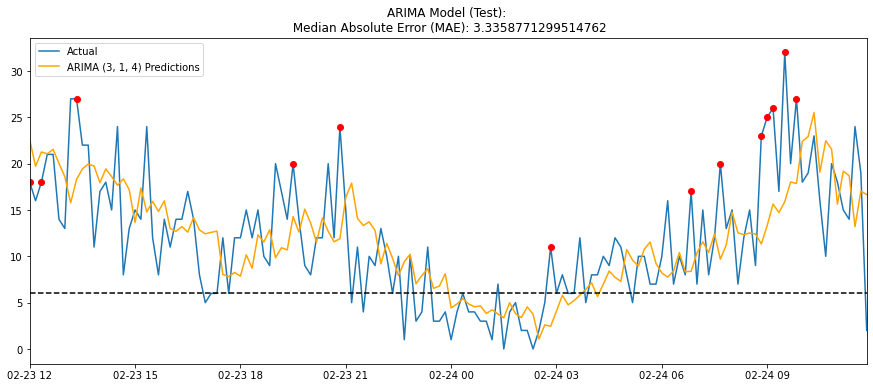

In [1324]:
fitted_values_actual = pd.Series(\
        standard_scaler_negative_sentiment.inverse_transform(model_ARIMA_2_results_metrics.actualvalues),\
        index = model_ARIMA_2_results_metrics.actualvalues.index)
fitted_values_predicted = pd.Series(\
        standard_scaler_negative_sentiment.inverse_transform(model_ARIMA_2_results_metrics.fittedvalues),\
        index = model_ARIMA_2_results_metrics.fittedvalues.index)

mae_error = median_absolute_error(fitted_values_predicted,fitted_values_actual)


#Plot curves
plt.figure(figsize=(15,6))
plt.xlim(start_date, end_date)
plt.plot(fitted_values_actual, label="Actual")
plt.plot(fitted_values_predicted, color='orange', label=f"ARIMA {model_arima_order} Predictions")
#plt.axhline(median_value, linestyle='--', color='k')
plt.plot(fitted_values_actual[-int(sliding_window_size):].loc[model_ARIMA_2_results_metrics['anomaly']==1], \
        marker='o', linestyle='None', color='red'
    )
plt.legend()

plt.title(f"ARIMA Model (Test): \n Median Absolute Error (MAE): {mae_error}")
    
predictions

# Forecasting

### Get Forecasted Results

In [1325]:
# The number of forecasts per sliding window will be the number of AR lags, as ARIMA can't forecast beyond that
num_lags = model_arima_order[0]

# The total lag time that will be forecasted (in minutes)
total_forecast_window = 30 # (we assume a daily sample rate)

# The size of the sliding window
sliding_window_size = total_forecast_window/data_freq

# The number of sliding windows will be ( size of the sliding window / num_lags )
num_sliding_windows = sliding_window_size/num_lags

# The dataset to forecast with
df = actual_negative_sentiments_train

# The predictions
predictions = pd.Series([])

# Initialize the start & end indexes
end_idx = len(df)

for idx in np.arange(num_sliding_windows):
    # Compute the start & end indexes
    end_idx = end_idx + num_lags
    start_idx = end_idx - sliding_window_size
    print(f'DEBUG: {start_idx} {end_idx} {end_idx-start_idx} {len(actual_negative_sentiments_train)} {len(actual_negative_sentiments)}')
    tmp_data = actual_negative_sentiments[int(start_idx):int(end_idx)]
    tmp_ARIMA = ARIMA(tmp_data['sentiment_normalized'], order=model_arima_order) 
    tmp_model_ARIMA_results = tmp_ARIMA.fit()
    pred = tmp_model_ARIMA_results.forecast(steps=num_lags, typ="levels").rename('forecasted')
    predictions = predictions.append(pred)
    
fitted_values_actual = pd.Series(\
        standard_scaler_negative_sentiment.inverse_transform(actual_negative_sentiments['sentiment_normalized']),\
        index = actual_negative_sentiments['sentiment_normalized'].index)
fitted_values_predicted = pd.Series(standard_scaler_negative_sentiment.inverse_transform(predictions), index = predictions.index)

predictions

DEBUG: 938.0 941 3.0 938 1082


2015-02-23 12:30:00-08:00    1.030703
2015-02-23 12:40:00-08:00    1.304890
2015-02-23 12:50:00-08:00    1.030717
Freq: 10T, dtype: float64

### Detect Anomalies

In [1326]:
z_score = st.norm.ppf(.95) #95% confidence interval
mae_scale_factor = 0.67449 # MAE is 0.67449 * std 
mae = median_absolute_error(actual_negative_sentiments['sentiment_normalized'].iloc[int(-sliding_window_size):],predictions)

threshold = median(predictions) + (z_score/mae_scale_factor)*mae
model_ARIMA_3_results_metrics = \
    pd.DataFrame({ 'fittedvalues' : predictions, \
      'median_values' : predictions.rolling(4).median().fillna(0)}, \
       index = predictions.index )
model_ARIMA_3_results_metrics['threshold'] = model_ARIMA_3_results_metrics['median_values'] + (z_score/mae_scale_factor)*mae
model_ARIMA_3_results_metrics['anomaly'] = 0
model_ARIMA_3_results_metrics['actualvalues'] = actual_negative_sentiments['sentiment_normalized']
model_ARIMA_3_results_metrics.loc[model_ARIMA_3_results_metrics['actualvalues'] > model_ARIMA_3_results_metrics['threshold'],'anomaly']= 1
model_ARIMA_3_results_metrics['anomaly'].value_counts()
model_ARIMA_3_results_metrics

,fittedvalues,median_values,threshold,anomaly,actualvalues
2015-02-23 12:30:00-08:00,1.030703,0.0,2.674796,0,1.716217
2015-02-23 12:40:00-08:00,1.304890,0.0,2.674796,0,1.716217
2015-02-23 12:50:00-08:00,1.030717,0.0,2.674796,0,0.756484


### Plot Curves

2015-02-23 12:30:00-08:00    1.030703
2015-02-23 12:40:00-08:00    1.304890
2015-02-23 12:50:00-08:00    1.030717
Freq: 10T, dtype: float64

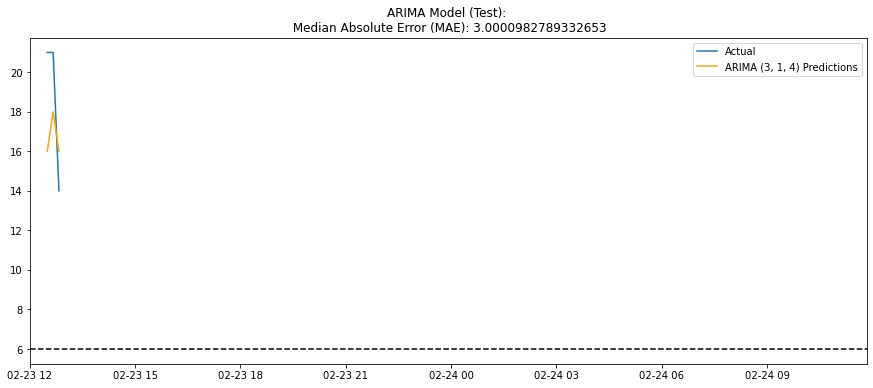

In [1327]:
fitted_values_actual = pd.Series(\
        standard_scaler_negative_sentiment.inverse_transform(model_ARIMA_3_results_metrics.actualvalues),\
        index = model_ARIMA_3_results_metrics.actualvalues.index)
fitted_values_predicted = pd.Series(\
        standard_scaler_negative_sentiment.inverse_transform(model_ARIMA_3_results_metrics.fittedvalues),\
        index = model_ARIMA_3_results_metrics.fittedvalues.index)

mae_error = median_absolute_error(fitted_values_predicted,fitted_values_actual)

#Plot curves
plt.figure(figsize=(15,6))
plt.xlim(start_date, end_date)
plt.plot(fitted_values_actual, label="Actual")
plt.plot(fitted_values_predicted, color='orange', label=f"ARIMA {model_arima_order} Predictions")
#plt.axhline(median_value, linestyle='--', color='k')
plt.plot(fitted_values_actual[int(-sliding_window_size):].loc[model_ARIMA_3_results_metrics['anomaly']==1], \
        marker='o', linestyle='None', color='red'
    )
plt.legend()

plt.title(f"ARIMA Model (Test): \n Median Absolute Error (MAE): {mae_error}")
    
predictions

# Utilities

In [1]:
import pika
import sys

In [45]:
#Publisher Class
class Publisher():
    def __init___(self, queue):
        self.queue = queue
    def on_channel_open(self, chn):
        self.channel = chn
        self.connection.add_timeout(0.1, self.schedule_next_message)
    def schedule_next_message(self):
        try:
            msg = f'Have another message! {datetime.now()}'
            self.channel.basic_publish('rabbitanalytics3-stream-exchange','anomaly.all',msg)
        except Queue.Empty:
            pass
        self.connection.add_timeout(0.1, self.schedule_next_message)
    def on_open(self, conn):
        self.connection = conn
        self.connection.channel(on_open_callback=self.on_channel_open)
    def run(self):
        # create a connection
        self.connection = pika.SelectConnection(
            pika.ConnectionParameters(
                host='rmqservice.tanzudatatap.ml',
                credentials=pika.PlainCredentials('data-user', 'data-password')),
            self.on_open)
        try:
            self.connection.ioloop.start()
        except Exception:
            print("exception in publisher")
            self.connection.close()
            self.connection.ioloop.start()

In [ ]:
#CONSUMER
import pika

# Create a global channel variable to hold our channel object in
channel = None

# Step #2
def on_connected(connection):
    """Called when we are fully connected to RabbitMQ"""
    # Open a channel
    connection.channel(on_open_callback=on_channel_open)

# Step #3
def on_channel_open(new_channel):
    """Called when our channel has opened"""
    global channel
    channel = new_channel
    channel.queue_declare(queue="rabbitanalytics3-stream", durable=False, callback=on_queue_declared)

# Step #4
def on_queue_declared(frame):
    """Called when RabbitMQ has told us our Queue has been declared, frame is the response from RabbitMQ"""
    channel.basic_consume('rabbitanalytics3-stream', handle_delivery)

# Step #5
def handle_delivery(channel, method, header, body):
    """Called when we receive a message from RabbitMQ"""
    print("Received a message!...{body}")
    
def on_connection_error(connection, error):
    print('Error while attempting to connect...')
    print(error)
    print(connection)

# Step #1: Connect to RabbitMQ using the default parameters
#parameters = pika.ConnectionParameters(host='rmqservice.tanzudatatap.ml',credentials=pika.PlainCredentials('data-user', 'data-password')))
parameters = pika.ConnectionParameters(host='rabbitanalytics3.data-samples-w07-s003.svc.cluster.local',credentials=pika.PlainCredentials('data-user', 'data-password'))
connection = pika.SelectConnection(parameters, on_open_callback=on_connected)
connection.add_on_open_error_callback(on_connection_error)

try:
    # Loop so we can communicate with RabbitMQ
    connection.ioloop.start()
except KeyboardInterrupt:
    # Gracefully close the connection
    connection.close()
    # Loop until we're fully closed, will stop on its own
    connection.ioloop.start()

In [ ]:
#PRODUCER
import pika
import time
import datetime

# Create a global channel variable to hold our channel object in
channel = None

# Step #2
def on_connected(connection):
    """Called when we are fully connected to RabbitMQ"""
    # Open a channel
    connection.channel(on_open_callback=on_channel_open)

# Step #3
def on_channel_open(new_channel):
    """Called when our channel has opened"""
    print('should have been here')
    global channel
    channel = new_channel
    print('here too')
    t_end = time.time() + 10
    print(t_end)
    while time.time() < t_end:
        msg = f'Have another message{time.time()}'
        print(msg)
        channel.basic_publish('rabbitanalytics3-stream-exchange','anomalyall',msg,pika.BasicProperties(content_type='text/plain',delivery_mode=pika.DeliveryMode.Persistent))
        print('and here')

# Step #4
def on_queue_declared(frame):
    """Called when RabbitMQ has told us our Queue has been declared, frame is the response from RabbitMQ"""
    channel.basic_consume('rabbitanalytics3-stream', handle_delivery)

# Step #5
def handle_delivery(channel, method, header, body):
    """Called when we receive a message from RabbitMQ"""
    print("Received a message!...{body}")

def on_closed(connection, error):
    print(error)
    print(connection)
    
def on_connection_error(connection, error):
    print('Error while attempting to connect...')
    print(error)
    print(connection)


# Step #1: Connect to RabbitMQ using the default parameters
#parameters = pika.ConnectionParameters(host='rmqservice.tanzudatatap.ml',credentials=pika.PlainCredentials('data-user', 'data-password')))
parameters = pika.ConnectionParameters(host='rmqdata-samples-w07-s003.tanzudatatap.ml',credentials=pika.PlainCredentials('data-user', 'data-password'))
connection = pika.SelectConnection(parameters, on_open_callback=on_connected, on_close_callback=on_closed)
connection.add_on_open_error_callback(on_connection_error)

try:
    # Loop so we can communicate with RabbitMQ
    connection.ioloop.start()
except KeyboardInterrupt:
    # Gracefully close the connection
    connection.close()
    # Loop until we're fully closed, will stop on its own
    connection.ioloop.start()


# Metrics

In [3]:
from prometheus_client import start_http_server, Summary
import random
import time

# Create a metric to track time spent and requests made.
REQUEST_TIME = Summary('request_processing_seconds_x', 'Time spent processing request')

# Decorate function with metric.
@REQUEST_TIME.time()
def process_request(t):
    """A dummy function that takes some time."""
    time.sleep(t)

#if __name__ == '__main__':
#    # Start up the server to expose the metrics.
#    start_http_server(8000)
#    # Generate some requests.
#    while True:
#        process_request(random.random())